# Practical Session 4 -  Atlas estimation

# Vrushank Agrawal

**!! Careful!! : To Do Practical Session 4 you need the code of Practical Session 3. Finish PS3 before starting this one.** 

In the previous Practical Session you have seen how to register an image $I_0$ to an image $I_1$ using the LDDMM framework. In that framework, the entire deformation $\phi$ is parameterized by the initial momentas of the control points $\alpha$. We optimize alpha to obtain a good, smooth fit between the registered image and the target. 

In shape analysis, we aim at computing a "mean" for a set of shapes/images. An atlas is formed of a **template** shape/image $I_0$, that captures common features of all subjects $(I_i)_{1 \leq i \leq N}$, together with a set of deformations (parameterized by $(\alpha^{(i)})_{1 \leq i \leq N}$)between template and individuals. Deformations should transcribe shape variability among a population.

In this pratical session, we perform atlas estimation on a set of digits images. 

<!-- If the deformations pulls the subject back to the template, this is **backward model**. \
Else, if the template is transported toward individuals this is **forward model**. -->

In [2]:
import numpy as np
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import torch
%matplotlib inline

tensor_type = torch.DoubleTensor

# Import data

In this practical session, images will be a set of digits, to register from a template digit.
There are 20 digits, but you should test yor algorithm on a sample of the set to confirm it's working.

In [3]:
# Run this the first time you launch the kernel on Colab.
! git clone https://github.com/AgatheSenellart/DataMAA308.git
! mv DataMAA308/data data
! mv DataMAA308/Images Images 

fatal: destination path 'DataMAA308' already exists and is not an empty directory.
mv: cannot stat 'DataMAA308/data': No such file or directory
mv: cannot stat 'DataMAA308/Images': No such file or directory


In [4]:
images_dict = {}
for i in range(1,21):
    images_dict[i] = np.array(mpimg.imread("./Images/digits/digit_2_sample_{}.png".format(i))) 
digit_template =  np.array(mpimg.imread("./Images/digits/digit_2_mean.png")) 

subset_images_dict = {i:images_dict[i] for i in range(1,1+3)}

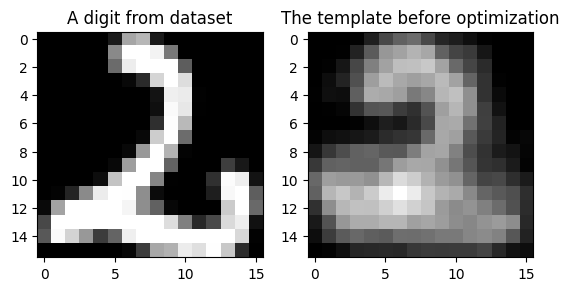

In [5]:
plt.subplot(1,2,1)
plt.imshow(images_dict[1],cmap='gray')
plt.title('A digit from dataset')
plt.subplot(1,2,2)
plt.imshow(digit_template,cmap='gray')
plt.title('The template before optimization')
plt.show()

# Functions from Practical Session 3

Reuse functions from the Practical Session 3; you can just copy your code from the previous practical session into the cell below.

In [6]:
# Functions from previous practical session: nothing to fill in here

def interpolate_image(intensities, deformed_pixels, padding_width=1):
    '''
    This function, given original image in intensities tensor, 
    deformed pixels : coordinates of registered pixels in original image,
    returns the final registered image in deformed_intensities
    ------- 
    intensities : (nr,nc)
    deformed_pixels : (nr*nc,d)
    -------
    returns registered image in deformed_intensities, of shape (nr,nc)
    
    '''
    padding_color = 1.
    if intensities.ndim == 2:
        i,j = intensities.size()
        k = 1
        intensities_cp = intensities[...,np.newaxis]
    else :
        i,j,k = intensities.size()
        intensities_cp = intensities
        
    deformed_pixels += torch.from_numpy(np.array([float(padding_width), float(padding_width)])).view(1, 2).expand(i*j, 2).type(torch.DoubleTensor)

    padded_intensities = torch.ones((i + 2 * padding_width, j + 2 * padding_width, k)).type(torch.DoubleTensor) * padding_color
    padded_intensities[padding_width:padding_width + i, padding_width:padding_width + j] = intensities_cp

    u, v = deformed_pixels[:, 0], deformed_pixels[:, 1]

    u1 = torch.floor(u)
    v1 = torch.floor(v)

    u1 = torch.clamp(u1, 0, i - 1 + 2 * padding_width)
    v1 = torch.clamp(v1, 0, j - 1 + 2 * padding_width)
    u2 = torch.clamp(u1 + 1, 0, i - 1 + 2 * padding_width)
    v2 = torch.clamp(v1 + 1, 0, j - 1 + 2 * padding_width)

    fu = (u - u1).view(i * j, 1).expand(i*j, k)
    fv = (v - v1).view(i * j, 1).expand(i*j, k)
    gu = ((u1 + 1) - u).view(i * j, 1).expand(i*j, k)
    gv = ((v1 + 1) - v).view(i * j, 1).expand(i*j, k)

    deformed_intensities = (padded_intensities[u1.type(torch.LongTensor), v1.type(torch.LongTensor)] * gu * gv +
                            padded_intensities[u1.type(torch.LongTensor), v2.type(torch.LongTensor)] * gu * fv +
                            padded_intensities[u2.type(torch.LongTensor), v1.type(torch.LongTensor)] * fu * gv +
                            padded_intensities[u2.type(torch.LongTensor), v2.type(torch.LongTensor)] * fu * fv).view(i, j, k)
    deformed_intensities = torch.clamp(deformed_intensities, 0., 1.)

    return deformed_intensities.reshape(intensities.size())

def plot_large_deformation_grid(traj_cp, traj_alpha, image, kernel_width,ax):
    
    '''
    Returns a grid of the deformation field computed with traj_cp and traj_alpha lists.
    -----
    traj_cp : list of length equals to the number of steps of the algorithm (n_step)
    traj_alpha : list of length equals to the number of steps of the algorithm (n_step)
    image : (nr,nc,k)
    '''
    
    i,j,_ = image.shape
    downsampling_factor = 5
    i_ = i // downsampling_factor
    j_ = j // downsampling_factor
    
    points = np.array(np.meshgrid(range(i_), range(j_))) * downsampling_factor
    points = np.swapaxes(points, 0, 2).reshape(i_ * j_, 2)
    points = torch.from_numpy(points).type(tensor_type)
    deformed_points = register_points(traj_cp, traj_alpha, points, kernel_width)[-1]
    
    g = deformed_points.detach().numpy().reshape(i_, j_, 2)
    ax.plot([g[:, :-1, 1].ravel(), g[:, 1:, 1].ravel()],
            [g[:, :-1, 0].ravel(), g[:, 1:, 0].ravel()], 'k', linewidth=1.2, marker='o', markersize=0.2)
    ax.plot([g[:-1, :, 1].ravel(), g[1:, :, 1].ravel()],
            [g[:-1, :, 0].ravel(), g[1:, :, 0].ravel()], 'k', linewidth=1.2, marker='o', markersize=0.2)

print("Import of functions from last session : \n"
      "- interpolate_image \n"
      "- plot_large_deformation_grid\n")

Import of functions from last session : 
- interpolate_image 
- plot_large_deformation_grid



In [7]:
# LDDMM registration functions from PS3 : nothing to fill in here
def _differences(x, y):
    
    """ 
    x is of shape (n, 2)
    y is of shape (m, 2)
    --------
    returns the difference between each element of x and y in a (2,n,m) tensor
    
    """
    x_col = x.t().unsqueeze(2)  # (n,D=2) -> (D,n,1)
    y_lin = y.t().unsqueeze(1)  # (m,D) -> (D,1,m)
    return x_col - y_lin

def _squared_distances(x, y):
    
    """ 
    x is of shape (n, 2)
    y is of shape (m, 2)
    
    --------
    returns the squared euclidean distance between each element of x and y in a (n,m) tensor
    
    """
    
    x_norm = (x ** 2).sum(1).view(-1, 1)
    y_norm = (y ** 2).sum(1).view(1, -1)

    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))
    return dist


def gaussian_kernel(x, y, kernel_width):
    """ 
    x is of shape (n, 2)
    y is of shape (m, 2)
    kernel_width is a value
    
    --------
    returns the gaussian kernel value between each element of x and y in a (n,m) tensor
    
    """

    squared_dist = _squared_distances(x, y)
    return torch.exp(- squared_dist / kernel_width **2 )

def h_gradx(cp, alpha, kernel_width):
    
    '''
    This function computes derivative of the kernel for each couple (cp_i,alpha_i), with cp_i a control point(landmark).
    ---------
    
    cp is of shape (n_landmarks, 2)
    alpha is of shape (n_landmarks, 2)
    kernel_width is a value
    
    --------
    returns a tensor of shape (n_landmarks, 2)
    '''
    
    sq = _squared_distances(cp, cp)
    A = torch.exp(-sq / kernel_width **2)
    B = _differences(cp, cp) * A
    
    return - 2 * B / (kernel_width ** 2)
    # return (- 1 * torch.sum(alpha * (torch.matmul(B, alpha)), 2) / (kernel_width ** 2)).t()
    
    


In [8]:
# Functions implemented in Practical Session 3 : Copy your implementations to fill the functions here
def discretisation_step(cp, alpha, dt, kernel_width):
    
    '''
    
    This function computes a step of discretized equations for both alpha and control points on one step. 
    Compute here a displacement step  of control points an alpha, from discretized system seen in class.
    ---------
    
    cp is of shape (n_landmarks, 2)
    alpha is of shape (n_landmarks, 2)
    dt is your time step 
    kernel_width is a value
    
    --------
    
    returns resulting control point and alpha displacements in tensors of size (n_landmarks,2) both.
    
    '''

    cp_result = cp + dt * torch.matmul(gaussian_kernel(cp, cp, kernel_width), alpha)
    h_grad = h_gradx(cp, alpha, kernel_width)
    alpha_t = ((-1/2) * torch.sum(alpha * (torch.matmul(h_grad, alpha)), 2)).t()
    alpha_result = alpha + dt * alpha_t
    return cp_result, alpha_result    


def shoot(cp, alpha, kernel_width, n_steps=10):
     
    """
    This is the trajectory of a Hamiltonian dynamic, with system seen in lecture notes. 
    Compute here trajectories of control points and alpha from t=0 to t=1.
    ------------
    cp is of shape (n_landmarks, 2)
    alpha is of shape (n_landmarks, 2)
    n_step : number of steps in your hamiltonian trajectory, use to define your time step
    kernel_width is a value
    --------
    returns traj_cp and traj_alpha trajectories of control points and alpha in lists. 
    The length of a list is equal to n_step. 
    In each element of the list, you have a tensor of size (n_landmarks,2) returned by discretisation_step() function.
    """
    
    traj_cp = [cp]
    traj_alpha = [alpha]
    
    for i in range(n_steps):
        new_cp, new_alpha = discretisation_step(traj_cp[-1], traj_alpha[-1], 1/(n_steps), kernel_width)
        traj_cp.append(new_cp)
        traj_alpha.append(new_alpha)
        
    return traj_cp, traj_alpha


def register_points(traj_cp, traj_alpha, y, kernel_width):
    """
    This is the application of the computed trajectories on a set of points (landmarks or new points).
    ------------
    
    traj_cp is the list containing the trajectory of your landmarks 
    traj_alpha is is the list containing the trajectory of your alpha 
    y : points you want to register (landmarks or other points), size (n,2)
    kernel_width is a value
    
    --------
    
    returns traj_y,  the trajectory of points y, in a list of length n_step. 
    In each element of the list, you should have an array of dimension (n,2) (same dimensions as y)
    
    
    """
    
    traj_y = [y]
    n_steps = len(traj_cp)
    dt = 1/float(n_steps)
    
    for i in range(n_steps):
        prev_y = traj_y[-1]
        new_y = prev_y + dt * torch.matmul(gaussian_kernel(prev_y, traj_cp[i], kernel_width), traj_alpha[i])
        traj_y.append(new_y)
    
    return traj_y


def inverse_register_points(traj_cp, traj_alpha, y, kernel_width):
    """
    ------------
    
    Compute inverse deformation of points y in a tensor named deformed_points, by using the previously defined register_points() function
    
    ------------
    
    traj_cp is the list containing the trajectory of your landmarks 
    traj_alpha is the list containing the trajectory of your alpha 
    y : The set of points to register with the inverse deformation
    kernel_width is a value
    
    --------
    
    returns the inverse registered points y (n, 2)
    
    """
    
    traj_cp_inverse = traj_cp[::-1]
    traj_alpha_inverse = [-i for i in traj_alpha[::-1]]
    return register_points(traj_cp_inverse, traj_alpha_inverse, y, kernel_width)[-1]


def register_image(traj_cp, traj_alpha, image, kernel_width):
    """
    This is the application of the computed trajectories on an image, by computation of inversed phi_1.
    ------------
    traj_cp is the list containing the trajectory of your landmarks 
    traj_alpha is the list containing the trajectory of your alpha 
    image : image to register, of size (nr,nc,channels)
    kernel_width is a value
    --------
    returns the registered image, of same dimensions as image, (nr,nc)
    
    """
    
    i,j = image.shape        
    points = np.array(np.meshgrid(range(i), range(j)))
    points = np.swapaxes(points, 0, 2).reshape(i*j, 2) 
    points = torch.from_numpy(points).type(tensor_type)
    inv_points = inverse_register_points(traj_cp, traj_alpha, points, kernel_width)
    
    return interpolate_image(image, inv_points)

# Atlas estimation

Before starting the implementation of the atlas estimation, let us summarize what you have up until here :
- `shoot` allows you to compute the evolution of control points and momentas $\alpha$ given an initial position.
- `register_points` allows you to apply the LDDMM deformation $\phi$ (given by the the trajectories of control points and alphas) to a set of points y. 
- `inverse_register_points` allows you to apply the inverse deformation $\phi^{-1}$ to a set of points y. 
- `register_image` allows you to apply the deformation $\phi$ to an image $I_0$ by computing $I_0\circ\phi^{-1}$.

In atlas estimation we aim at finding an optimal template image $I_0$ and an optimal set of deformations $(\phi^{(i)})_{1\leq i \leq N}$ to minimize :

\begin{equation}
E = \sum_{i=1}^{N} |I_i - I_0\circ(\phi^{(i)})^{-1}|^2 + \gamma ||v_0^{(i)}||_V^2
\end{equation}

- Each deformation $\phi^{(i)}$ is parameterized by the initial momentas $\alpha^{(i)}$ as in Practical Session 3.
- For any $i \in [|1,N|]$, the norm of the initial velocity is given by $||v_0^{(i)}||_V^2 = \sum_{(j,k)} K(x_j,x_k)(\alpha_j^{(i)})^T(\alpha_k^{(i)})$ where we sum over all the pairs of landmarks.

The first term in $E$ is the **attachment term** that describes how well the images are reconstructed by the deformation of the template and the the second term is a **regularization term** that penalizes the kinetic energy going from $I_0$ to $I_i$. 

We optimize $E$ with regards to $I_0$ and the $(\alpha^{(i)})_{1\leq i \leq N}$.

**TODO 1 : Compute the energy E for a given template image $I_0$ and deformations $\phi^{(i)}$** 

- First loop over the subjects $i \in [|1,N|]$ to compute the energy term per subject. 

- Then,compute total attachment and total regularity.
The total cost function is already written at the end of the function (in `total` object).

- Read the function description and be careful of the expected output shapes. 

Good luck !

In [9]:
def compute_attachment_regularity_gradient(cp,alpha,template_data,subjects,kernel_width,gamma):
    '''
    TO DO
    CAUTION : you only use torch tensors here, no numpy objects
    ----------
    This function compute attachments and regularities in order to compute the loss and optimize momenta and template with gradient descent.
    In order to do this, you have to deform the control points and the template as with LDDMM, for each image/subject.
    Then compute attachment and regularity for each pair of deformed template and points.
    And finally the total attachment and the total regularity.
    The total loss is already computed.
    ------ 
    cp : tensor (n_landmarks,2)
    alpha : tensor (n_landmarks,2,n_images)
    template_data : tensor (nr,nc)
    subjects : tensor (nr,nc,n_images)
    kernel_width and gamma : parameters, values
    ----- 
    returns 4 objects :
    attachement is a tensor with only one value inside, ex. tensor(10.0)
    regularity is a tensor with only one value inside, same
    deformed template according to each subject : tensor (nr,nc,n_images) 
    deformed control points according to each subject : tensor (n_landmarks,2,n_images)
    '''

    n_landmarks = cp.size()[0]
    n_images = alpha.size()[2]
    nr, nc = template_data.size()

    K = gaussian_kernel(cp, cp, kernel_width)
    attachement = torch.zeros(n_images)
    regularization = torch.zeros(n_images)
    deformed_template = torch.zeros(nr, nc, n_images)
    deformed_control_points = torch.zeros(n_landmarks, 2, n_images)

    for i in range(n_images):
        traj_cp, traj_alpha = shoot(cp, alpha[:,:,i], kernel_width)
        deformed_template[:,:,i] = register_image(traj_cp, traj_alpha, template_data, kernel_width)
        deformed_control_points[:,:,i] = traj_cp[-1]
        attachement[i] = torch.norm(subjects[:,:,i] - deformed_template[:,:,i])**2
        K_alpha = torch.matmul(torch.transpose(alpha[:,:,i], 0, 1), K)
        regularization[i] = gamma*(torch.norm(torch.matmul(K_alpha, alpha[:,:,i]))**2)

    total_attachment = torch.sum(attachement)
    total_regularity = torch.sum(regularization)

    #################
    ### Here is computed the total loss and its gradient 
    # with torch.backward()
    total = total_attachment + total_regularity
    total.backward()
    return total_attachment.detach(),total_regularity.detach(),deformed_template.detach(),deformed_control_points.detach()

In [10]:
# Basic test to check that your function compiles and provides the right output shapes
test_cp = torch.arange(1,8*2+1).reshape(8,2).type(tensor_type)
test_alpha = torch.zeros((test_cp.size(0),test_cp.size(1),4)).type(tensor_type)
test_template = torch.from_numpy(digit_template).type(tensor_type)
test_alpha.requires_grad_(True)
test_template.requires_grad_(True)
test_subjects = torch.stack([test_template]*4, dim=-1)
test_kernel_width = 0.5
test_gamma = 1
output = compute_attachment_regularity_gradient(test_cp,test_alpha,test_template,test_subjects,test_kernel_width,test_gamma)
for obj in output:
    print(obj.shape)

torch.Size([])
torch.Size([])
torch.Size([16, 16, 4])
torch.Size([8, 2, 4])


We provide you with the main function that performs atlas estimation using the function implemented above.

In [11]:
def atlas_learn_template(images,niter,kernel_width,gamma,eps,template=None,landmarks=None):
    
    '''
    This is the main function, which computes gradient descent to minimize cost function,
    and find optimal trajectories for control points, alpha and deformed template.
    Take a dictionary with images, 
    niter : number of iterations, 
    kernel_width and gamma : parameters, 
    eps for step size of gradient descent,
    template and landmarks are optionals.
    -------
    returns 
    cp : deformation of  control points to match with each subject : numpy array (n_landmarks,2,n_images)
    alpha : optimized momenta,  numpy array (n_landmarks,2,n_images)
    template_data : the optimized template, numpy array (nr,nc) 
    deformed_template : deformation of template according to each image,  numpy array (nr,nc,n_images)

    '''

  
    ## Convert the dictionnary of images to a 3 dimensional array (nr,nc,n_images)
    
    Images = images[1]
    for key, value in images.items():
        if key==2:
            Images = np.stack((Images,value),axis=-1)   
        elif key !=1 :
            Images = np.concatenate((Images,value[...,np.newaxis]),axis=-1)   

    Images_base = torch.from_numpy(Images.copy()).type(tensor_type)
    
    
    ### Convert template, if given, to a tensor (nx,ny)
    ### If no template is provided, take first image of set
    if template is None :
        template_data = torch.from_numpy(Images[...,0].copy()).type(tensor_type)  
    else :
        template_data = torch.from_numpy(template).type(tensor_type)
        
    #### Initialize control points
    #### Here, with digits database, no control points are provided, 
    #### So we build a regular grid with interval equals to kernel_width.
    #### You can plot control points to see where they are exactly.
    #### cp tensor is of  shape (n_landmarks,2) with y-axis coordinates in first column and x-axis coordinates in second column
    
    if landmarks is not None :
        cp = torch.from_numpy(landmarks).type(tensor_type)
    else :
        cp = np.array(np.meshgrid(np.arange(0,template.shape[0]-2,kernel_width), np.arange(0,template.shape[1]-2,kernel_width)))
        cp = np.swapaxes(cp, 0, 2).reshape(-1, 2) 
        cp = torch.from_numpy(cp).type(tensor_type)
        
    ##### Plot template at the beginning and first original digits
    
    plt.figure()
    plt.subplot(1,5,1)
    plt.imshow(template_data.detach().numpy(),cmap='gray')
    plt.title("Template")
    for i in range(min(4,Images.shape[-1])):
        plt.subplot(1,5,i+2)
        plt.imshow(np.clip(Images[...,i],0,1),cmap='gray')
        plt.title(f'Im {i+1}')
    plt.show()
      
    ##### Initialize momenta
    number_of_subjects = Images_base.size(-1)
    alpha = torch.zeros((cp.size(0),cp.size(1),number_of_subjects)).type(tensor_type)
    alpha.requires_grad_(True)
    template_data.requires_grad_(True)
    
    #######################    
    #### Iterations    
        
    for it in range(niter):
        
        current_attachment, current_regularity,deformed_template,deformed_points = compute_attachment_regularity_gradient(cp,alpha,template_data,Images_base,kernel_width,gamma)
  
        gradient = {}
        gradient['alpha'] = alpha.grad.detach()
        gradient['template_data'] = template_data.grad.detach()

        eps_mom = eps/np.sqrt(np.sum(gradient['alpha'].numpy() ** 2))
        eps_template = eps/np.sqrt(np.sum(gradient['template_data'].numpy() ** 2)+10**-5)
        
        with torch.no_grad():
            alpha -=  alpha.grad * eps_mom
            template_data -=  template_data.grad * eps_template
            
        alpha.grad.zero_()
        template_data.grad.zero_()
        
                                                                                
       
  
        attach_val = current_attachment.numpy()
        regul_val = current_regularity.numpy()
        
        if it % 40 == 0 or it == niter:
            print('------------------------------------- Iteration: ' + str(it)  + ' -------------------------------------')
            print(f"-----> Attachement loss : {attach_val}")
            print(f"-----> Regularization loss : {regul_val}")
          
            ##### Plot template and deformed template according to first digits

            plt.figure()
            plt.subplot(1,5,1)
            plt.imshow(np.clip(template_data.detach().numpy(),0,1),cmap='gray')
            plt.title('Template')
            for i in range(min(4,Images.shape[-1])):
                plt.subplot(1,5,i+2)
                plt.imshow(np.clip(deformed_template.detach().numpy()[...,i],0,1),cmap='gray')
                plt.title(f'Recon {i}')
            plt.show()
    

    
    return cp.detach().numpy(),alpha.detach().numpy(),np.clip(template_data.detach().numpy(),0,1),deformed_template.detach().numpy()

# Execution of the Atlas Estimation

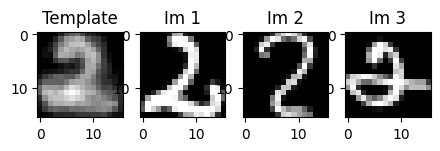

------------------------------------- Iteration: 0 -------------------------------------
-----> Attachement loss : 83.36795043945312
-----> Regularization loss : 0.0


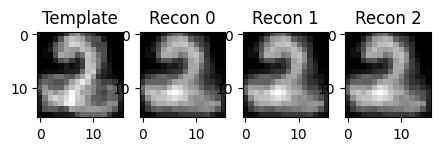

------------------------------------- Iteration: 40 -------------------------------------
-----> Attachement loss : 23.17464828491211
-----> Regularization loss : 4.30904483795166


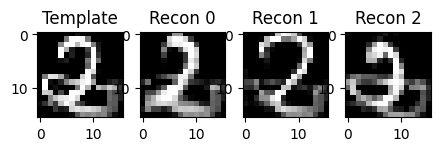

------------------------------------- Iteration: 80 -------------------------------------
-----> Attachement loss : 21.387712478637695
-----> Regularization loss : 4.660161018371582


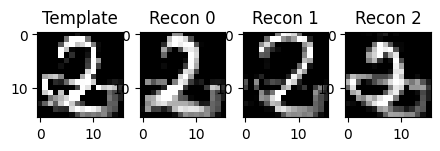

------------------------------------- Iteration: 120 -------------------------------------
-----> Attachement loss : 21.677446365356445
-----> Regularization loss : 4.805131912231445


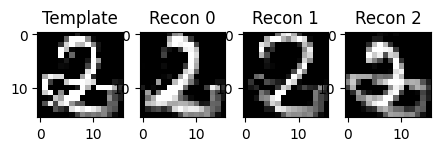

------------------------------------- Iteration: 160 -------------------------------------
-----> Attachement loss : 18.056575775146484
-----> Regularization loss : 5.305745601654053


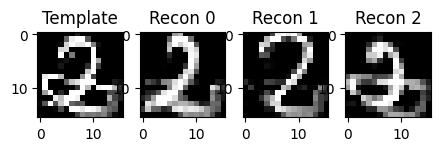

------------------------------------- Iteration: 200 -------------------------------------
-----> Attachement loss : 17.60025405883789
-----> Regularization loss : 5.357630729675293


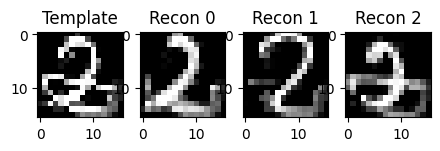

------------------------------------- Iteration: 240 -------------------------------------
-----> Attachement loss : 21.286901473999023
-----> Regularization loss : 5.989001750946045


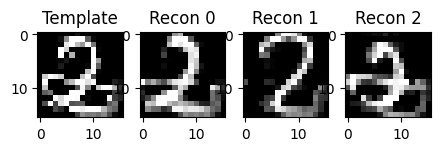

------------------------------------- Iteration: 280 -------------------------------------
-----> Attachement loss : 19.033737182617188
-----> Regularization loss : 6.171518325805664


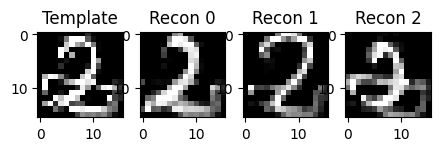

------------------------------------- Iteration: 320 -------------------------------------
-----> Attachement loss : 18.069915771484375
-----> Regularization loss : 6.5643768310546875


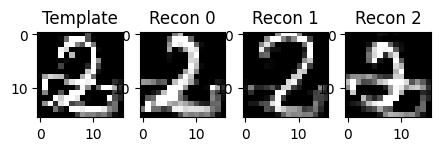

------------------------------------- Iteration: 360 -------------------------------------
-----> Attachement loss : 18.596893310546875
-----> Regularization loss : 6.526243209838867


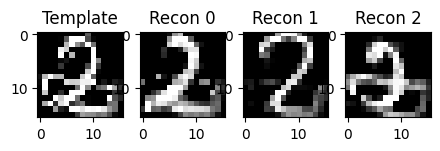

In [16]:
eps = 1 ## Don't play with this one

#### You are strongly advised to test different values of the parameters below.

kernel_width = 2.
niter = 400
gamma = 0.01


## Execution of the algorithm
images = subset_images_dict ### Use a subset of the images
# images = images_dict ### Uncomment this to use all the images instead of a subset.
control_points, momenta,optim_template,deformed_digits = atlas_learn_template(images,niter,kernel_width,gamma,eps,template=digit_template,landmarks=None)


## Obtained template at the end of the atlas estimation algorithm

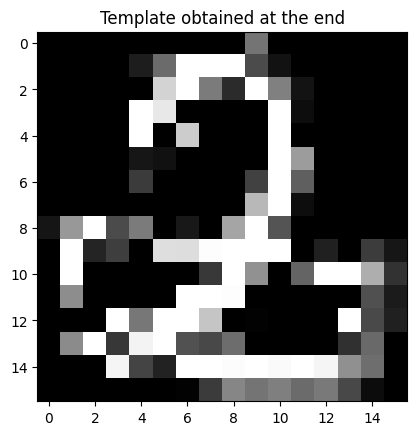

In [17]:
plt.figure()
plt.imshow(optim_template,cmap='gray')
plt.title("Template obtained at the end")
plt.show()

## Deformed template for each digit

3


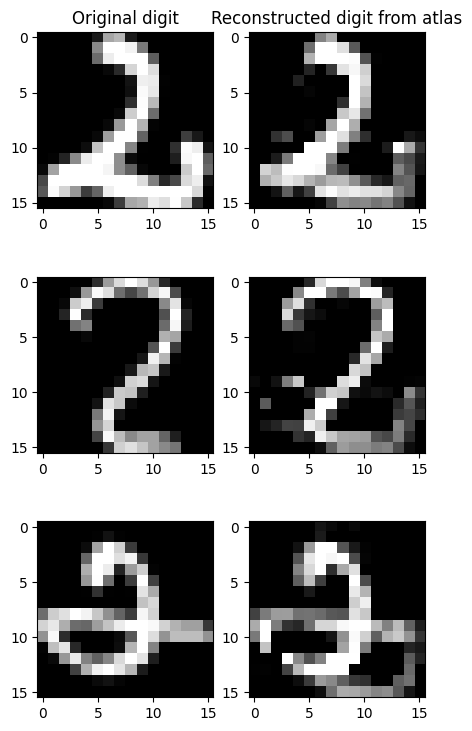

In [18]:
n_subjects = deformed_digits.shape[-1]
print(n_subjects)
plt.figure(figsize=(5,3*n_subjects))
number_image = 1

for i in images.keys():
    plt.subplot(n_subjects,2,number_image)
    plt.imshow(images[i],cmap='gray')
    if i==1:
        plt.title('Original digit')

    plt.subplot(n_subjects,2,number_image+1)
    plt.imshow(deformed_digits[...,i-1],cmap='gray')
    if i==1:
        plt.title('Reconstructed digit from atlas')

    number_image += 2
plt.show()

**TODO 2 : Play with the parameters. What are their effects on the atlas estimation ?**

Gamma: This is the regularity variable that is used to parameterize the $\Vert v\Vert^2$ term or the velocity term in the equation. Essentially, it is observed that increasing gamma makes the image more blurry while a low gamma makes them very sharp

n_iter: As we iterate longer, the overall loss decreses over time and so the error is also reduced but after a certain point (100 iterations) it tends to become static and the  images do not change much.

Kernel_width: A larger kernel_width increases the smoothness of the reconstructed images as was observed in the previous TD.

# Execution on noised images


**TODO 3 :**
-  Add gaussian noise to the input images : In order to do this, create a new dictionary `noised_image_dict` with the noised images. 
- Execute again the atlas estimation algorithm in next cells, on noisy images. 
- What happens when you try to estimate an atlas on noisy images ?


Adding noise to the images adds contrast in the images in the sense that we have random pixels now that are whiter and blacker than the original image. The reconstructed images with atlast estimation also have noise.

(16, 16)


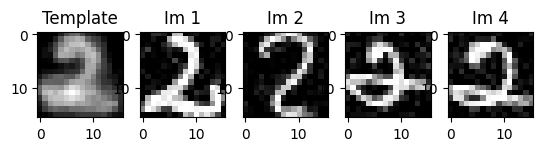

------------------------------------- Iteration: 0 -------------------------------------
-----> Attachement loss : 607.5372924804688
-----> Regularization loss : 0.0


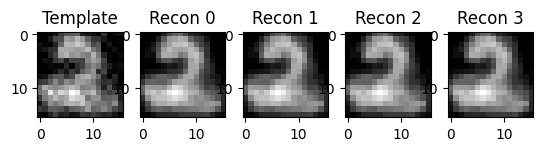

------------------------------------- Iteration: 40 -------------------------------------
-----> Attachement loss : 222.3797149658203
-----> Regularization loss : 51.96831130981445


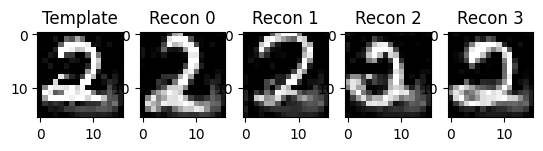

------------------------------------- Iteration: 80 -------------------------------------
-----> Attachement loss : 199.47171020507812
-----> Regularization loss : 57.51637268066406


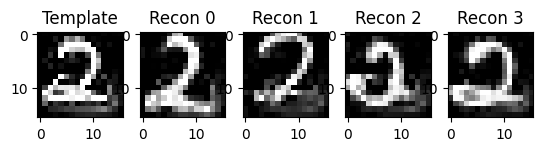

In [27]:
eps = 1
kernel_width = 2.
niter = 100
gamma = 0.01

from random import gauss

print(images_dict[1].shape)
# shape is 16 x 16

noised_image_dict = {}
for i in range(1,21):
    noise = np.array([gauss(0,0.1) for i in range(images_dict[i].size)]).reshape(16,16)
    noised_image_dict[i] = images_dict[i] + noise

## Execution of the algorithm
control_points, momenta,optim_template,deformed_digits = atlas_learn_template(noised_image_dict,niter,kernel_width,gamma,eps,template=digit_template,landmarks=None)

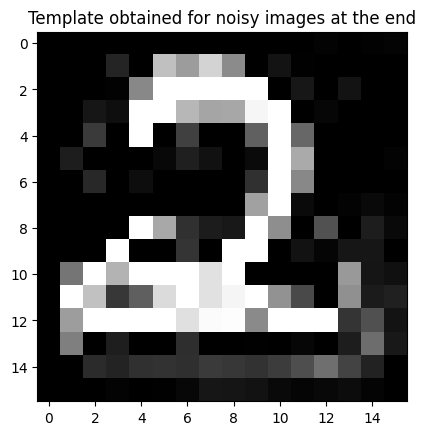

In [28]:
plt.figure()
plt.imshow(optim_template,cmap='gray')
plt.title("Template obtained for noisy images at the end")
plt.show()

20


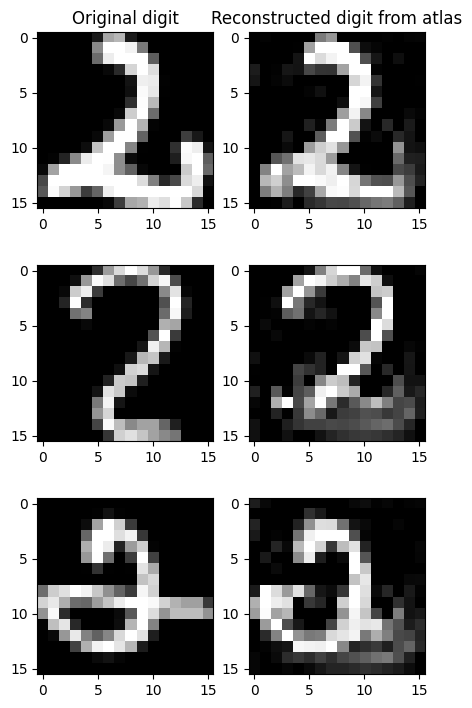

In [29]:
n_subjects = deformed_digits.shape[-1]
print(n_subjects)
plt.figure(figsize=(5,3*n_subjects))
number_image = 1

for i in images.keys():
    plt.subplot(n_subjects,2,number_image)
    plt.imshow(images[i],cmap='gray')
    if i==1:
        plt.title('Original digit')

    plt.subplot(n_subjects,2,number_image+1)
    plt.imshow(deformed_digits[...,i-1],cmap='gray')
    if i==1:
        plt.title('Reconstructed digit from atlas')

    number_image += 2
plt.show()